In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, ConvexHull
import copy

In [16]:
# ------------------------
# PARAMETERS
# ------------------------
WIDTH = 380
HEIGHT = 280
NUM_VOTERS = 1000
NUM_PARTIES = 3
NUM_DISTRICTS = 8
VOTERS_PER_DISTRICT = NUM_VOTERS // NUM_DISTRICTS
NUM_RUNS = 10  # Number of simulations for now
np.random.seed(1)

PARTY_IDS = [f"Party {i}" for i in range(NUM_PARTIES)]
party_colors = np.random.rand(NUM_PARTIES, 3)
PARTY_COLORS = dict(zip(PARTY_IDS, party_colors))


In [17]:

# ------------------------
# GENERATE VOTERS
# ------------------------
voters = np.column_stack((
    np.random.uniform(0, WIDTH, NUM_VOTERS),
    np.random.uniform(0, HEIGHT, NUM_VOTERS)
))

# ------------------------
# CONNECTED DISTRICTS (BFS method)
# ------------------------
def connected_districts(voters, num_districts, voters_per_district, k_neighbors=20):
    N = len(voters)
    district = -np.ones(N, dtype=int)
    tree = cKDTree(voters)
    unassigned = set(range(N))

    for d in range(num_districts):
        if not unassigned:
            break
        seed = np.random.choice(list(unassigned))
        district[seed] = d
        unassigned.remove(seed)
        queue = [seed]
        count = 1
        while queue and count < voters_per_district:
            current = queue.pop(0)
            _, neighbors = tree.query(voters[current], k=k_neighbors)
            for n in neighbors:
                if n in unassigned:
                    district[n] = d
                    unassigned.remove(n)
                    queue.append(n)
                    count += 1
                    if count >= voters_per_district:
                        break
        if count < voters_per_district:
            # reset and retry
            for i in range(N):
                if district[i] == d:
                    district[i] = -1
                    unassigned.add(i)
            return connected_districts(voters, num_districts, voters_per_district)
    return district

district_labels = connected_districts(voters, NUM_DISTRICTS, VOTERS_PER_DISTRICT)


# ------------------------
# EFFICIENCY GAP FUNCTION
# ------------------------
def efficiency_gap(district_counts):
    gaps = []
    for d in district_counts:
        winner = max(d, key=d.get)
        num_votes = sum(d.values())
        wasted_winner = d[winner] - num_votes/2
        wasted_loser = num_votes - d[winner]
        gaps.append((wasted_winner - wasted_loser) / num_votes)
    return gaps

# ------------------------
# SIMULATE ONE ELECTION
# ------------------------
def simulate_election(voters, district_labels):
    voter_parties = np.random.randint(0, NUM_PARTIES, len(voters))
    voter_colors = party_colors[voter_parties]
    district_counts = []
    for d in range(NUM_DISTRICTS):
        mask = district_labels == d
        counts = {party:0 for party in PARTY_IDS}
        for i in np.where(mask)[0]:
            counts[PARTY_IDS[voter_parties[i]]] += 1
        district_counts.append(counts)
    return voter_parties, voter_colors, district_counts



# ------------------------
# VOTE SHIFT SIMULATION
# ------------------------
def simulate_vote_shifts(district_counts, target_party):
    counts = copy.deepcopy(district_counts)
    competitors = [p for p in PARTY_IDS if p != target_party]
    def district_winner(d): return max(d, key=d.get)
    def count_target_wins(): return sum(1 for d in counts if district_winner(d)==target_party)
    def vote_share(): return sum(d[target_party] for d in counts)/sum(sum(d.values()) for d in counts)
    current_wins = count_target_wins()
    history = []
    shift = 0
    initial_wins = current_wins
    initial_share = vote_share()
    while True:
        shift +=1
        any_competitor = False
        for d in counts:
            moved = 0
            for p in competitors:
                if d[p]>0:
                    d[p]-=1
                    moved+=1
            if moved>0: any_competitor=True
            d[target_party]+=moved
        new_wins = count_target_wins()
        if new_wins>current_wins:
            history.append({"shift": shift, "districts_won": new_wins, "vote_share": vote_share()})
            current_wins=new_wins
        if not any_competitor or new_wins==NUM_DISTRICTS:
            break
    return {"history": history, "initial_wins": initial_wins, "initial_vote_share": initial_share}

def simulate_reverse_shifts(district_counts, target_party):
    counts = copy.deepcopy(district_counts)
    competitors = [p for p in PARTY_IDS if p != target_party]
    def district_winner(d): return max(d, key=d.get)
    def count_target_wins(): return sum(1 for d in counts if district_winner(d)==target_party)
    def vote_share(): return sum(d[target_party] for d in counts)/sum(sum(d.values()) for d in counts)
    current_wins = count_target_wins()
    history = []
    shift = 0
    initial_wins = current_wins
    initial_share = vote_share()
    while True:
        shift +=1
        any_target=False
        for d in counts:
            moved=0
            if d[target_party]>0:
                moved=d[target_party]
                d[target_party]=0
                for p in competitors: d[p]+=moved//len(competitors)
                any_target=True
        new_wins=count_target_wins()
        if new_wins<current_wins:
            history.append({"shift":shift,"districts_won":new_wins,"vote_share":vote_share()})
            current_wins=new_wins
        if not any_target or new_wins==0:
            break
    return {"history": history, "initial_wins": initial_wins, "initial_vote_share": initial_share}

# ------------------------
# RUN MULTIPLE SIMULATIONS
# ------------------------

all_efficiency_gaps = []
all_seat_counts = []
all_vote_shares = []

for run in range(NUM_RUNS):

    # New random election each time
    voter_parties, voter_colors, district_counts = simulate_election(voters, district_labels)

    # Efficiency gap
    gaps = efficiency_gap(district_counts)
    all_efficiency_gaps.append(np.mean(gaps))

    # Seat count for Party 0
    seats_won = sum(
        1 for d in district_counts
        if max(d, key=d.get) == "Party 0"
    )
    all_seat_counts.append(seats_won)

    # Vote share for Party 0
    total_votes = sum(sum(d.values()) for d in district_counts)
    party0_votes = sum(d["Party 0"] for d in district_counts)
    vote_share = party0_votes / total_votes
    all_vote_shares.append(vote_share)

# Convert to numpy arrays
all_efficiency_gaps = np.array(all_efficiency_gaps)
all_seat_counts = np.array(all_seat_counts)
all_vote_shares = np.array(all_vote_shares)

# ------------------------
# SUMMARY STATISTICS
# ------------------------

print("\n----- MULTI-RUN SUMMARY -----")
print("Number of runs:", NUM_RUNS)

print("\nEfficiency Gap:")
print("  Mean:", np.mean(all_efficiency_gaps))
print("  Std Dev:", np.std(all_efficiency_gaps))





----- MULTI-RUN SUMMARY -----
Number of runs: 10

Efficiency Gap:
  Mean: -0.741
  Std Dev: 0.017464249196572995


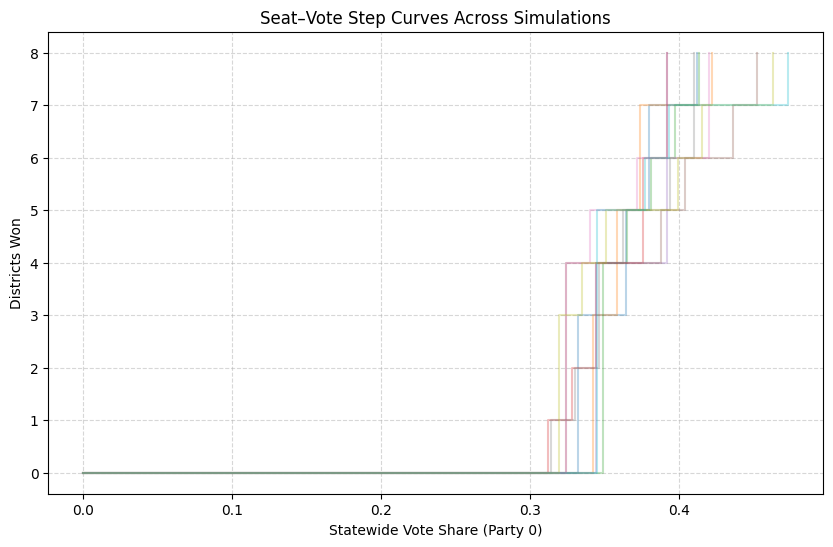

In [18]:
#   Plot an overlay each curve for each run


plt.figure(figsize=(10,6))

for run in range(NUM_RUNS):
    voter_parties, voter_colors, district_counts = simulate_election(voters, district_labels)

    results_fwd = simulate_vote_shifts(district_counts, target_party="Party 0")
    results_rev = simulate_reverse_shifts(district_counts, target_party="Party 0")

    initial_vote = results_fwd["initial_vote_share"]
    initial_seats = results_fwd["initial_wins"]

    fwd = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_fwd["history"]
    ]
    rev = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_rev["history"]
    ]

    merged = sorted(set(fwd + rev))
    x, y = zip(*merged)

    plt.step(x, y, where="post", alpha=0.3)

plt.xlabel("Statewide Vote Share (Party 0)")
plt.ylabel("Districts Won")
plt.title("Seat–Vote Step Curves Across Simulations")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


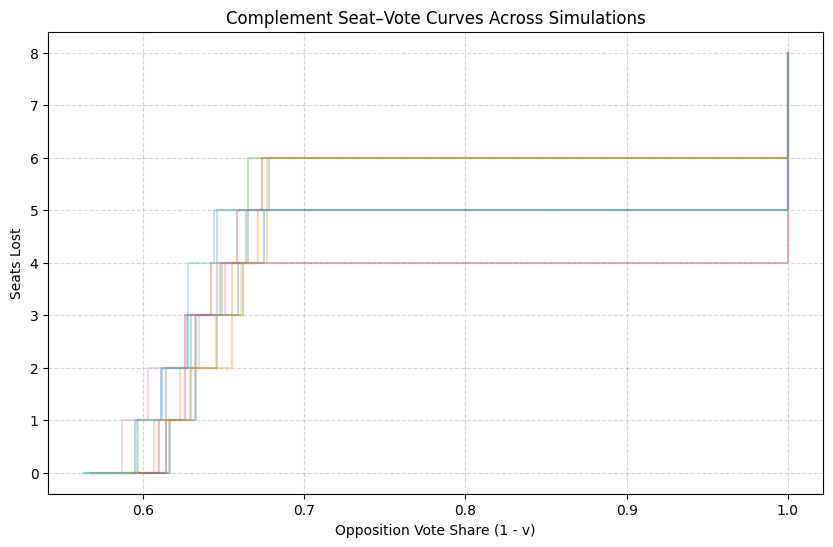

In [19]:
# complement curves 



plt.figure(figsize=(10,6))

for run in range(NUM_RUNS):

    voter_parties, voter_colors, district_counts = simulate_election(voters, district_labels)

    results_fwd = simulate_vote_shifts(district_counts, target_party="Party 0")
    results_rev = simulate_reverse_shifts(district_counts, target_party="Party 0")

    initial_vote = results_fwd["initial_vote_share"]
    initial_seats = results_fwd["initial_wins"]

    fwd = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_fwd["history"]
    ]
    rev = [(initial_vote, initial_seats)] + [
        (h["vote_share"], h["districts_won"]) for h in results_rev["history"]
    ]

    merged = sorted(set(fwd + rev))
    comp = [(1-v, NUM_DISTRICTS - s) for v, s in merged]
    comp = sorted(comp)

    x, y = zip(*comp)
    plt.step(x, y, where="post", alpha=0.3)

plt.xlabel("Opposition Vote Share (1 - v)")
plt.ylabel("Seats Lost")
plt.title("Complement Seat–Vote Curves Across Simulations")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
